Examining Twitter data model and list down node labels and relationship properties.


In [1]:
import os
import json
import urllib.parse
from py2neo import Graph

with open('credentials_neo4j.json') as f:
    login = json.load(f)

username = login['username']
password = urllib.parse.quote(login['password'])
host = login['host']
url = "neo4j+s://{}".format(host)

# This is our neo4j Connection Object:
graph = Graph(uri = url,
              user = username,
              password = password,
             secure=True,
             routing=True)


nodes = graph.run("""
MATCH (u:USER) 
RETURN DISTINCT labels(u) AS node
""").data()
nodes

[{'node': ['USER']}]

In [3]:
user_relationship = graph.run("""
MATCH  (u:USER)-[r]-> ()
RETURN DISTINCT type(r) AS RelationshipType
""").data()
user_relationship

[{'RelationshipType': 'Retweeted'}, {'RelationshipType': 'Replied'}]


Node Labels: USER

Relationship properties: Retweeted , Replied


Continuing our work with Cashtags and tweets, we want to understand better if there are individuals or networks of individuals who may have been working together to tweet about particular sets of stocks. Here, we want to identify one individual, the most prolific tweeter, and see (1) how many people they have relationships with and (2) the average number of relationships those first-order individuals have.

*3a*. Identify the `USER` with the highest number of tweets (in the `count` property of `USER` nodes) by returning their `userid`:


In [5]:
most = graph.run("""
MATCH (u:USER)
RETURN u.count AS TweetCount
ORDER BY u.count DESC
LIMIT 1
""").data()
print(most)

[{'TweetCount': 4544}]


3b. The person with the highest number of tweets is not necessarily the person with the most connections (we'll see if there is a relationship in part 'c'). Now we want to find the person with the highest number of relationships. 

Print the userid and number of relationships:


In [7]:
most = graph.run("""
MATCH (a:USER)-[r]-(b:USER)
WHERE a <> b
RETURN a.userid AS UserID, COUNT(r) AS RelationshipCount
ORDER BY RelationshipCount DESC
LIMIT 1
""").data()
print(most)

[{'UserID': 3772910893, 'RelationshipCount': 1078}]


3c. We want to see if there is a relationship between the number of tweets a user makes and the size of their local network. We don't want to return all records, so we'll aggregate by the size of the `USER`s tweet `count`. Return the *average* number of connections for individuals within each unique tweet count bin. We then want to plot the tweet count against the average number of relationships those users have.


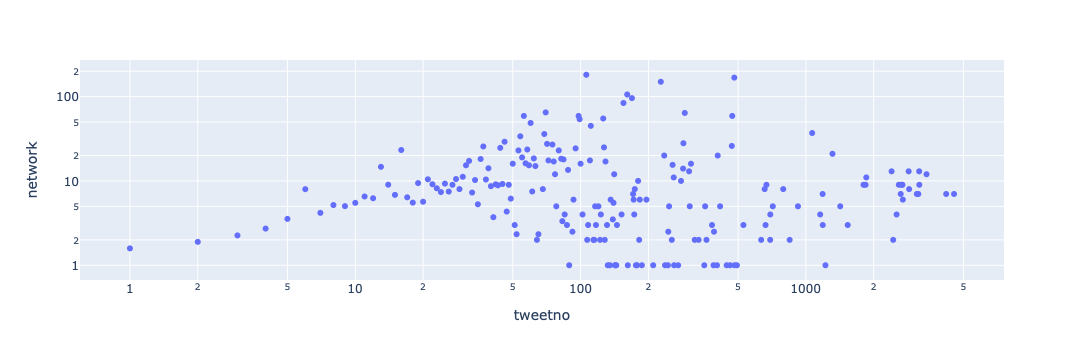

In [13]:
import plotly.express as px

results = graph.run("""
MATCH (a:USER)-[r]-(b:USER)
WHERE a <> b
WITH a, count(r) AS relationships, a.count AS tweetno
RETURN tweetno, AVG(relationships) AS network
ORDER BY tweetno
""").data()

## tweetno: Unique tweet count ## network: Average number of connections
px.scatter(results, x="tweetno", y="network", log_x=True, log_y=True)

3d. Describe the relationship you see between the number of tweets an individual makes and the size of their network. Is the relationship consistent? Why might you see a change in the relationship?

Answer: Overall, we see a positive relationship between the number of tweets and network with tweetno is really low, but as tweetno gets large, there is no consistent relationship found between the two variables. This wider-spread scatter towards larger tweetno may be due to the fact that as the number of tweets increases for an account, they have higher chances to attract more audiences due to higher exposure. Therefore as the number of tweets get larger, some accounts get famous due to luck, higher quality tweets and some other factors. Whereas some other accounts stay unnoticed due to their inability to attract audiences, since not all active tweeters are high quality content producers.

4a. Given the userid in 3b, return the 'USER's that the user is linked to. Then, in the same query (using the `WITH` statement), identify the ***average number of people those 1st order relations are linked to***, and ***the standard deviation (function `stDev()`) of that number***. Exclude all relationships where a person replies or retweets themselves.


In [17]:
### fill in the blanks
counts = graph.run("""
  MATCH (u:USER)-[r]-(ub)
  WHERE u.userid = 3772910893 AND u <> ub
  MATCH (ub:USER)-[rb]-(uc:USER)
  WHERE ub <> uc
  WITH DISTINCT ub AS second, COUNT(rb) AS secondLinks
  RETURN AVG(secondLinks), stDev(secondLinks)
  LIMIT 1""").data()
print(counts)

[{'AVG(secondLinks)': 1.6493506493506482, 'stDev(secondLinks)': 0.848536095595718}]


4b. Take the code you've written in 3b and 4a.  In those cases we've treated relationships as undirected, we assume that people who retweet others have just as much influence in the network as people who write the tweets that are retweeted.  This is not particularly likely.  It's far more likely that the person being retweeted, and being replied to has more influence.

Given this, re-estimate the "most influential" person (3b) considering that influence flows from the primary content, so in the relationship `(ua:USER)<-[]-(ub:USER)`, it is `ua` who has the influence.  Use the `userid` from your new answer to recalculate your answer in 3b, taking direction into account. 

In [31]:
counts = graph.run("""
MATCH (ua:USER)<-[r]-(ub:USER)
WHERE ua <> ub
WITH ua, COUNT(r) AS RelationshipCount
ORDER BY RelationshipCount DESC
LIMIT 1

MATCH (ua)<-[r]-(ub:USER)
WHERE ua <> ub
MATCH (ub)-[rb]-(uc:USER)
WHERE ub <> uc
WITH DISTINCT ub AS second, COUNT(rb) AS secondLinks, ua, RelationshipCount
RETURN ua.userid AS UserID, RelationshipCount, AVG(secondLinks), stDev(secondLinks)
""").data()
print(counts)

[{'UserID': 2801334731, 'RelationshipCount': 150, 'AVG(secondLinks)': 10.113333333333333, 'stDev(secondLinks)': 45.313751363574184}]


4c. Why are these counts different with 3b and 4b (just answer to the point using ~3 sentences)?

Answer: This is because when identifying the most influential person, the title has been given to the person who has been replied to the most. Whereas in the original codes in 3b, the most influential person was defined as the person who had the most interactions with other accounts, including both replying/retweeting and being replied/retweeted to. Since the definition of the most influential person changed, then it is not surprising that the results have changed as well.

5. Ask a question and answer it using your Twitter graph database.

Question: What is the most common interaction type among the top 10 most followed users?

Reasoning: The first step is to identify the top 10 users by relationship count, which uses the same logic as 4b where influential users are those receiving replies and retweets. The second step is to count the different types of interactions, and compare to see which one is more prevalent. This step would be different to the previous questions by dividing the relationship types up in the query. A visualisation using plotly can then be applied to better understand the dynamics of the engagement since the outputs are quite messy, which can be achived by aggregating the counts of each interaction and plotting them against each other.

[{'UserID': 2801334731, 'TotalRetweets': 150, 'TotalReplies': 0, 'TotalInteractions': 150}, {'UserID': 808873082500902915, 'TotalRetweets': 106, 'TotalReplies': 0, 'TotalInteractions': 106}, {'UserID': 728433956169752576, 'TotalRetweets': 94, 'TotalReplies': 0, 'TotalInteractions': 94}, {'UserID': 168817124, 'TotalRetweets': 84, 'TotalReplies': 0, 'TotalInteractions': 84}, {'UserID': 152048643, 'TotalRetweets': 76, 'TotalReplies': 0, 'TotalInteractions': 76}, {'UserID': 128374098, 'TotalRetweets': 64, 'TotalReplies': 0, 'TotalInteractions': 64}, {'UserID': 164482211, 'TotalRetweets': 62, 'TotalReplies': 0, 'TotalInteractions': 62}, {'UserID': 2391736411, 'TotalRetweets': 60, 'TotalReplies': 2, 'TotalInteractions': 62}, {'UserID': 166053109, 'TotalRetweets': 59, 'TotalReplies': 0, 'TotalInteractions': 59}, {'UserID': 434470669, 'TotalRetweets': 59, 'TotalReplies': 0, 'TotalInteractions': 59}]


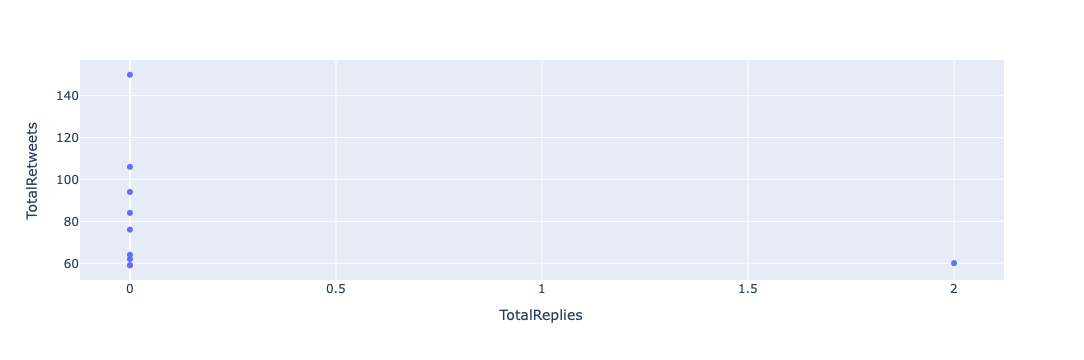

In [21]:
common = graph.run("""
MATCH (ua:USER)<-[r:Retweeted|Replied]-(ub:USER)
WHERE ua <> ub
WITH ua, r
WITH ua,
     SUM(CASE WHEN TYPE(r) = "Retweeted" THEN 1 ELSE 0 END) AS TotalRetweets,
     SUM(CASE WHEN TYPE(r) = "Replied" THEN 1 ELSE 0 END) AS TotalReplies
WITH ua, TotalRetweets, TotalReplies, (TotalRetweets + TotalReplies) AS TotalInteractions
ORDER BY TotalInteractions DESC
LIMIT 10
RETURN ua.userid AS UserID, TotalRetweets, TotalReplies, TotalInteractions
""").data()
print(common)
px.scatter(common, x="TotalReplies", y="TotalRetweets")